#TODO
method prop支持classification
q oracle功能未实现

In [14]:
from sklearn.model_selection import StratifiedKFold,cross_val_predict
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd
import copy

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn import linear_model

In [15]:
data=pd.read_csv("D:\Rworkspace\LDML\data.csv",index_col=0)
data.index=data.index-1
cv=pd.read_csv("D:\Rworkspace\LDML\cvgroup.csv",index_col=0)
cv.index=cv.index-1

cvgroup=[]
for i in range(1,6):
    train=cv[cv!=i].dropna().index.values
    test=cv[cv==i].dropna().index.values
    cvgroup.append((train,test))

gammas=[0.25,0.5,0.75]
form_x=["age","inc","educ","fsize","marr","twoearn","db","pira","hown" ]
form_t="p401"
form_y="net_tfa"

z=0# test pointer

In [16]:
#databackend 
from double_ml_data import DoubleMLData
dataset=DoubleMLData(data,"net_tfa","p401",x_cols=["age","inc","educ","fsize","marr","twoearn","db","pira","hown" ])

In [4]:
#learners
from sklearn.ensemble import RandomForestRegressor
learner = RandomForestRegressor(n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)
learner = RandomForestClassifier(n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)

In [5]:
#using ldml
from ldml import LocalizedDML
final_model=LocalizedDML([0.25,0.5,0.75],dataset,5,learner,learner,learner,trim_type='clip',semiadaptive=False)

In [6]:
final_model.methods

{'method_ipw': RandomForestClassifier(max_depth=7, max_features=3, min_samples_leaf=3,
                        n_estimators=50),
 'method_prop': RandomForestClassifier(max_depth=7, max_features=3, min_samples_leaf=3,
                        n_estimators=50),
 'method_cdf': RandomForestClassifier(max_depth=7, max_features=3, min_samples_leaf=3,
                        n_estimators=50)}

In [6]:
final_model.ipw_fit()

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,1000.0,-1050.0,2050.0,0.845373,4.660248,4.805483
1,0.50,8000.0,499.0,7501.0,2.041217,1.037910,2.476268
2,0.75,29857.0,10600.0,19257.0,48.141794,6.907518,51.273225


In [7]:
final_model.fit()

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,280.0,-790.0,1070.0,4.164908,6.127408,7.657252
1,0.50,5599.0,999.0,4600.0,12.203241,1.560253,12.593756
2,0.75,23110.0,15348.0,7762.0,37.177142,5.863633,39.731975


In [10]:
#keep version
def cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop, trim=(0.01,0.99), trim_type='none', normalize=True):
    '''cross_val train and predict prop score, then process them'''
    #prop=np.zeros(data.shape[0]) 
    #for train_idx,test_idx in cvgroup:
    #    fitted_model=method_prop.fit(data.loc[train_idx][form_x],data.loc[train_idx][form_t])
    #    prop[test_idx] = fitted_model.predict(data.loc[test_idx][form_x])

    #t为自变量，x为因变量，进行kfold训练和预测
    #cv:An iterable that generates (train, test) splits as arrays of indices.
    prop=cross_val_predict(method_prop, data[form_x], data[form_t], cv=cvgroup)
    
    assert trim_type in ['none','drop','clip']
    if trim_type == 'drop':
        keep = np.logical_and(prop>trim[0],prop<trim[1])
        prop[~keep] = 0.5
    else:
        keep = np.full(data.shape[0],True) #otherwise,keep all rows  
        
    if trim_type == 'clip':
        prop=np.clip(prop,trim[0],trim[1])

    #we normalize propensity weights to have mean 1 within each treatment group
    #(In each group) P_i=P_i*MEAN(1/P_i),therefore 1/P_i would have mean 1
    global p
    p=[data[form_t][keep]*prop[keep]*np.mean(data[form_t][keep]/prop[keep])]
    if normalize:
        prop[keep] = data[form_t][keep]*prop[keep]*np.mean(data[form_t][keep]/prop[keep]) + \
                    (1.-data[form_t][keep])*(1.-(1.-prop[keep])*np.mean((1.-data[form_t][keep])/(1.-prop[keep])))
    
    return prop,keep

#测试
if True:
    method_prop=RandomForestRegressor(n_estimators=100, max_depth=7, max_features=3, min_samples_leaf=3)
    result=cross_fit_propensities(data, cvgroup,form_x ,form_t ,method_prop, trim=(0.01,0.99), trim_type='none', normalize=True)

In [11]:
def solve_cumsum(vector,c):
    '''Return i for i such that summing vector[1:i] is closest to c'''
    return pd.Series(abs(np.cumsum(vector)-c)).idxmin()#keep index info
#测试
solve_cumsum(pd.Series([1,2,3,4],index=[-3,-2,1,2]),2.1)

-2

In [12]:
def density(X, w, x):
    '''Estimate the density of data in X at point(s) x with weights w'''
    X=np.array(X)
    if X.ndim==1:
        X=X.reshape(-1,1)
    x=np.array([x]).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(X=X,sample_weight=w)#fit whole curve
    return np.exp(kde.score_samples(x))#predict points
#测试
density(np.array([1,2,3,4,5]),np.ones(5),np.array([1,2,3,4,5]))

array([0.15504953, 0.19754675, 0.19997058, 0.19754675, 0.15504953])

In [14]:
def est_quantile_ipw(gammas, data, form_x, form_t, form_y, method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='none', normalize=True, avg_eqn=True):
    """
    gammas:list
        quantiles to be estimated
    data:dataframe 
        dataset
    form_x:list of string
        specify columns for x
    form_t,form_y:string
        specify columns for t,y respectively (only support single treatment variable, so far)
    method_prop:estimator implementing ``fit()`` and ``predict()``
        method and option for propsperity score estimation, if treatment variable is binary, 
        then a classification model is acceptable
    K:int
        kfold_num
    trim:list or tuple
        upper and lower bound for trim_type=='clip'
    trim_type:str
        method use to deal with points which has extreme prop score,'drop' or 'clip' or 'none'
    normalize:bool
        whether to normalize prop score in each treatment group
    avg_eqn:bool
        if True, estimate q on whole data;
        else, estimate q in each fold, then take their mean as final estimation
    """
    #prepare for solve_cumsum 
    data.sort_values(by=form_y,ascending=True,inplace=True)
    data.reset_index(drop=True,inplace=True)

    #分层cv
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data[form_t]):
        cvgroup.append((train,test))#train,test are list, see demo1
    
    prop,keep = cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop,\
                                    trim=trim, trim_type=trim_type, normalize=normalize)

    w1=keep*data[form_t]/prop
    w0=keep*(1-data[form_t])/(1-prop)

    result=[]
    for i,gamma in enumerate(gammas):
        if avg_eqn:    
            q1=data[form_y][solve_cumsum(w1/sum(keep),gamma)]
            q0=data[form_y][solve_cumsum(w0/sum(keep),gamma)]
        else:
            q1_list=[]
            q0_list=[]
            for train,test in cvgroup:
                # solve_cumsum keeps origin index, so data[form_y] doesn't need to slice
                q1_list.append(data[form_y][solve_cumsum(w1[test]/sum(keep[test]),gamma)])
                q0_list.append(data[form_y][solve_cumsum(w0[test]/sum(keep[test]),gamma)])
            q1=np.mean(q1_list)
            q0=np.mean(q0_list)
        
        # sample value of score function/J, J is estimated by IPW kde at q
        keep_t1_mask=np.logical_and(data[form_t]==1,keep)
        keep_t0_mask=np.logical_and(data[form_t]==0,keep)
        # density result is different from R, is bigger
        psi1=(w1[keep]*(data[form_y][keep]<=q1)-gamma)/density(data[form_y][keep_t1_mask], 1/prop[keep_t1_mask], q1)
        psi0=(w0[keep]*(data[form_y][keep]<=q0)-gamma)/density(data[form_y][keep_t0_mask], 1/(1-prop[keep_t0_mask]), q0)#???

        se1 = np.std(psi1,ddof=1) / np.sqrt(sum(keep))
        se0 = np.std(psi0,ddof=1) / np.sqrt(sum(keep))
        seqte = np.std(psi1-psi0,ddof=1) / np.sqrt(sum(keep))

        result.append(pd.DataFrame({'gamma':gamma,'q1':q1,'q0':q0,'qte':q1-q0,\
                                    'se1':se1,'se0':se0,'seqte':seqte},index=[i]))
    
    return pd.concat(result,axis=0)
    
method_prop = linear_model.Lasso(alpha=0.5)
result=est_quantile_ipw(gammas, data, form_x, form_t, form_y, method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)
result

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,1402.0,-929.0,2331.0,10.709057,17.484004,21.452908
1,0.50,9675.0,611.0,9064.0,20.662696,21.735336,33.725706
2,0.75,34280.0,12800.0,21480.0,39.872399,11.985748,44.722102


In [ ]:
    """
    gammas:list
        quantiles to be estimated
    data:dataframe 
        dataset
    form_x:list of string
        specify columns for x
    form_t,form_y:string
        specify columns for t,y respectively (only support single treatment variable, so far)
    method_prop:estimator implementing ``fit()`` and ``predict()``
        method and option for propsperity score estimation, if treatment variable is binary, 
        then a classification model is acceptable
    method_ipw,method_cdf:
        same as method_prop
    K:int
        kfold_num
    K_ipw:int
        folds use to estimate fixed value for localization
        default value: np.ceil((K-1)/2)
    semiadaptive:bool
        if semiadaptive is set to TRUE then we use all out-of-fold data for both IPW and fitting nuisances,
        otherwise, out-of-fold data would be spilt into 2 parts for IPW and nuis1 estimation respectively
    trim:list or tuple
        upper and lower bound for trim_type=='clip'
    trim_type:str
        method use to deal with points which has extreme prop score,'drop' or 'clip' or 'none'
    normalize:bool
        whether to normalize prop score in each treatment group
    avg_eqn:
        if True, estimate q on whole data;
        else, estimate q in each fold, then take their mean as final estimation
    """

In [25]:
def est_quantile_ldml(gammas, data, form_x, form_t, form_y, method_ipw,method_prop, method_cdf,\
                     K=5, K_ipw=0, semiadaptive=False, trim=(0.01,0.99), trim_type='none',\
                     normalize=True, avg_eqn=True):
    #prepare for solve_cumsum 
    data.sort_values(by=form_y,ascending=True,inplace=True)
    data.reset_index(drop=True,inplace=True)
    
    skf = StratifiedKFold(n_splits=K)
    cvgroup=[]
    split_cvgroup=[]
    for train, test in skf.split(data, data[form_t]):
        cvgroup.append((train,test))#train,test are list, see demo1
        if not semiadaptive:
            l=len(train)
            ipw_train=train[:l//2]
            nuis1_train=train[l//2:]
            split_cvgroup.append((ipw_train,nuis1_train,test))
        else:
            split_cvgroup.append((copy.deepcopy(train),copy.deepcopy(train),test))#need copy???

    #nuis2
    prop,keep = cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop,\
                                    trim=trim, trim_type=trim_type, normalize=normalize)
    w1=keep*data[form_t]/prop
    w0=keep*(1-data[form_t])/(1-prop)

    if K_ipw==0:
        K_ipw=int(np.ceil((K-1)/2))#向上取整
    
    result=[]
    for i,gamma in enumerate(gammas):
        cdf0,cdf1=np.zeros(data.shape[0]),np.zeros(data.shape[0])

        for ipw_train,nuis1_train,test in split_cvgroup:
            #use take method instead of iloc, for automatiaclly copy
            ipw_result = est_quantile_ipw([gamma], data.take(ipw_train), form_x, form_t, form_y, method_ipw, \
                        K=K_ipw, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)

            def fit_predict(cdf,q):   
                cdf_goal=(data[form_y]<=ipw_result[q][0])
                cdf_fit=method_cdf.fit(data.take(nuis1_train),cdf_goal.take(nuis1_train))
                cdf[test]=cdf_fit.predict(data.take(test))

            fit_predict(cdf1,'q1')
            fit_predict(cdf0,'q0')

        def ldml_formula(w,cdf,q_num,mask):
            if q_num==1:
                p=(1.- data[form_t][mask]/prop[mask])
            elif q_num==0:
                p=(1.-data[form_t][mask])/(1.-prop[mask])

            return data[form_y][solve_cumsum(w[mask]/sum(mask),gamma - np.mean(cdf[mask]*p))]
            
        if avg_eqn:
            q1=ldml_formula(w1,cdf1,1,keep)
            q0=ldml_formula(w0,cdf0,1,keep)
        else:
            q1_list,q0_list=[],[]
            for ipw_train,nuis1_train,test in split_cvgroup:
                q1=ldml_formula(1,keep&test)
                q0=ldml_formula(0,keep&test)
            q1,q0=np.mean(q1_list),np.mean(q0_list)
        
        def score_func(w,q,cdf,q_num,mask):
            if q_num==1:
                p=(1.- data[form_t][mask]/prop[mask])
            elif q_num==0:
                p=(1.-data[form_t][mask])/(1.-prop[mask])        
            return (w[keep] * (data[form_y][keep] <= q)-gamma-cdf[mask]*p)

        # sample value of score function/J, J is estimated by IPW kde at q
        keep_t1_mask=np.logical_and(data[form_t]==1,keep)
        keep_t0_mask=np.logical_and(data[form_t]==0,keep)
        psi1=score_func(w1,q1,cdf1,1,keep)/density(data[form_y][keep_t1_mask], 1/prop[keep_t1_mask], q1)
        psi0=score_func(w0,q0,cdf0,0,keep)/density(data[form_y][keep_t0_mask], 1/(1-prop[keep_t0_mask]), q0)

        se1 = np.std(psi1,ddof=1) / np.sqrt(sum(keep))
        se0 = np.std(psi0,ddof=1) / np.sqrt(sum(keep))
        seqte = np.std(psi1-psi0,ddof=1) / np.sqrt(sum(keep))
        result.append(pd.DataFrame({'gamma':gamma,'q1':q1,'q0':q0,'qte':q1-q0,\
                                    'se1':se1,'se0':se0,'seqte':seqte},index=[i]))
    return pd.concat(result,axis=0)

method_prop = RandomForestRegressor(n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)
result=est_quantile_ldml(gammas, data, form_x, form_t, form_y, method_prop,method_prop,method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)
result

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,230.0,-784.0,1014.0,2.281702,20.117185,20.402086
1,0.50,5498.0,999.0,4499.0,27.391735,1.569034,27.718611
2,0.75,22635.0,15434.0,7201.0,44.707586,17.198735,53.276501


In [ ]:
#demo1
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print(train,test)
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 47 48 49] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 45 46]
train -  [30  3]   |   test -  [15  2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 49] [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 47 48]
train -  [30  3]   |   test -  [15  2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 45 46 47 48] [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49]
train -  [30  4]   |   test -  [15  1]
train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


In [ ]:
#demo-classification
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(penalty='l1',solver='liblinear',random_state=0).fit(X, y)
print(clf.predict(X[:2, :]))
clf.predict_proba(X[:2, :])

[0 0]


array([[8.85204244e-01, 1.14795704e-01, 5.16221340e-08],
       [7.93563244e-01, 2.06436477e-01, 2.79376439e-07]])

In [143]:
#demo-regressor
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(
    n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)
#model=randomForest.fit(X,y)
#print(model.predict(X))

# Missing Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from missing_data import MissingDataLinear

In [2]:
#data generate (Y missing)
import numpy as np
import pandas as pd
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    y=2*x1+0.5*x2+3*x3+np.random.normal(0, 1, n)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    y=np.where(mask==1,y,np.nan)
    #return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y},index=np.arange(n))

data=test_data_generator(n=1000)

In [3]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()

In [12]:
m=MissingDataLinear(data,'Y',['X1','X2','X3'],lm,5)

In [13]:
m.missing_y()

[1.9777364  0.50246221 3.00726966]


d:\jpt_workspace\casual_infer\missing_data.py:156: RuntimeWarning: invalid value encountered in sqrt
  PSI2=PSI2+psi.dot(psi.T)/len(test)


(array([1.9777364 , 0.50246221, 3.00726966]),
 array([0.0349621 , 0.02935422, 0.02449305]),
 array([[ 1.22234816e-03,  2.68425753e-05, -5.27831321e-04],
        [ 2.68425753e-05,  8.61670090e-04, -3.39945542e-04],
        [-5.27831321e-04, -3.39945542e-04,  5.99909695e-04]]))

In [5]:
#implementation of DML
from numpy.linalg import inv

def dml(data,form_x,form_y,model,K=5):
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu_dic={}
    psi_a=pd.DataFrame(0,index=form_x,columns=form_x)
    psi_b=pd.Series(0,index=form_x)
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x]
        Y=data.take(test)[form_y].fillna(0).values
        R=data.take(test)['R'].values

        #lambda=P(R=1|X)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu=E(Y|X,R=1)
        train_set=data.take(train).dropna()
        mu_model=model.fit(train_set[form_x],train_set[form_y].values)
        mu=mu_model.predict(X)
        mu_dic[str(i)]=mu#vector

        #psi_a=XX^T (the notion for X is reverse, i.e. X in python is X^T in paper)
        #psi_b=X[R(Y-mu)/lambda+mu]
        psi_a+=(X.T).dot(X)/len(test)
        psi_b+=X.T.dot(R*(Y-mu)/lambda_+mu)/len(test)

    coef=inv(psi_a).dot(psi_b)#main para to be estimated
    print(coef)

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=form_x,columns=form_x)
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x]
        Y=data.take(test)[form_y].fillna(0).values
        R=data.take(test)['R'].values

        lambda_=lambda_dic[str(i)]
        mu=mu_dic[str(i)]
        
        #notice the 'mul' here, not dot
        #right part is vector of shape (n_sample,)
        #left part is matrix of shape(form_x, n_sample)
        psi=X.T.mul(R*(Y-mu)/lambda_+mu-X.dot(coef))
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]
  
    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)

from sklearn.linear_model import LinearRegression
lm=LinearRegression()
dml(data,['X1','X2','X3'],'Y',lm)

[2.02315028 0.49145132 3.03310126]


C:\Users\11861\AppData\Local\Temp\ipykernel_12392\1346809964.py:62: RuntimeWarning: invalid value encountered in sqrt
  return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)


(array([2.02315028, 0.49145132, 3.03310126]),
 array([0.03238284, 0.03135773, 0.02268695]),
 array([[ 0.00104865, -0.00010404, -0.00036671],
        [-0.00010404,  0.00098331, -0.00033897],
        [-0.00036671, -0.00033897,  0.0005147 ]]))

In [4]:
def test_data_generator(n=1000,miss_ratio=0.1):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    y=2*x1+0.5*x2+3*x3+np.random.normal(0, 1, n)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    x1=np.where(mask==1,x1,np.nan)
    np.random.shuffle(mask)
    x2=np.where(mask==1,x2,np.nan)
    #return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y},index=np.arange(n))

data=test_data_generator(n=1000)

In [5]:
m=MissingDataLinear(data,'Y',['X1','X2','X3'],lm,5)
print(m)

Dependent variable: Y
Independent variables:['X1', 'X2', 'X3']
Missing variable(s): ['X1', 'X2']
Non-missing independent variable(s): ['X3']
No. Observations: 1000
Missing num: 187.0



In [6]:
def missing_x(self):
    data=self.data
    form_x=self.x_cols
    form_z=self.z_cols
    form_y=self.y_col

    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu1_dic={}
    mu2_dic={}
    psi_a=pd.DataFrame(0,index=form_x+form_z,columns=form_x+form_z)
    psi_b=pd.Series(0,index=form_x+form_z)

    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values.reshape(-1,len(form_x))
        Y=data.take(test)[form_y].values.reshape(-1,1)
        Z=data.take(test)[form_z].values.reshape(-1,len(form_z))
        R=data.take(test)['R'].values.reshape(-1,1)
        #lambda=P(R=1|Z,Y)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu1=E(X|Z,Y,R=1)
        #mu2=E(XX^T|Z,Y,R=1)
        train_set=data.take(train).dropna()
        mu1_model=self.model.fit(train_set[form_yz],train_set[form_x].values)
        mu1=mu1_model.predict(data.take(test)[form_yz])
        mu1_dic[str(i)]=mu1#vector

        XXT=element_squaredot(train_set[form_x].values)
        XXT=XXT.reshape(-1,len(form_x)**2)
        mu2_model = MultiOutputRegressor(self.second_model).fit(train_set[form_yz], XXT)
        mu2=mu2_model.predict(data.take(test)[form_yz])
        mu2=mu2.reshape(-1,len(form_x),len(form_x))#vector
        mu2_dic[str(i)]=mu2

        left_up=pd.DataFrame(sum(np.expand_dims(R,axis=2)*(element_squaredot(X)-mu2)/lambda_+mu2),index=form_x,columns=form_x)
        left_down=pd.DataFrame(Z.T.dot(R*(X-mu1)/lambda_+mu1),index=form_z,columns=form_x)
        right_down=pd.DataFrame(Z.T.dot(Z),index=form_z,columns=form_z)
        psi_a=psi_a+pd.concat([pd.concat([left_up,left_down.T],axis=1),\
                            pd.concat([left_down,right_down],axis=1)],axis=0)/len(test)
        
        psi_b=psi_b+pd.concat([pd.Series(sum(Y*(R*(X-mu1)/lambda_+mu1)),index=form_x),pd.Series((Z.T.dot(Y)).flatten(),index=form_z)],axis=0)/len(test)
        
    coef=inv(psi_a).dot(psi_b)
    coef=pd.DataFrame(coef,index=form_x+form_z)
    
    beta=coef.loc[form_x][0].values
    gamma=coef.loc[form_z][0].values

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=form_x+form_z,columns=form_x+form_z)

    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z].values.reshape(-1,len(form_z))
        R=data.take(test)['R'].values.reshape(-1,1)

        lambda_=lambda_dic[str(i)]
        mu1=mu1_dic[str(i)]
        mu2=mu2_dic[str(i)]

        up=(R*(X-mu1)/lambda_+mu1)*(Y-Z.dot(gamma)).reshape(-1,1)-(np.expand_dims(R,axis=2)*(element_squaredot(X)-mu2)/lambda_+mu2).dot(beta)
        down=Z.T*((Y-(R*(X-mu1)/lambda_+mu1).dot(beta))-Z.dot(gamma))
        up=pd.DataFrame(up,columns=form_x).T
        down=pd.DataFrame(down.T,columns=form_z).T
        psi=pd.concat([up,down],axis=0)
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]

    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)
missing_x(m)

NameError: name 'element_squaredot' is not defined

In [7]:
m.missing_x()

d:\jpt_workspace\casual_infer\missing_data.py:243: RuntimeWarning: invalid value encountered in sqrt
  return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)


(           0
 X1  1.886896
 X2  0.502091
 X3  3.047553,
 array([0.04072296, 0.03157621, 0.02340084]),
 array([[ 0.00165836, -0.00023391, -0.0005824 ],
        [-0.00023391,  0.00099706, -0.000242  ],
        [-0.0005824 , -0.000242  ,  0.0005476 ]]))

In [5]:
import copy
data2=copy.deepcopy(m.data)
data2['R']=data2['R'].astype('float')
data2

,X1,X2,X3,Y,R
0,0.989261,0.497318,1.955632,7.336381,1.0
1,2.327520,2.126147,2.153169,13.328937,1.0
2,0.070889,0.442016,2.050131,6.776526,1.0
3,0.803937,0.645409,1.856408,6.931701,1.0
4,NaN,NaN,0.392672,6.212940,0.0
...,...,...,...,...,...
995,1.762922,1.053268,1.442145,8.805329,1.0
996,1.754629,1.865505,1.240533,9.541490,1.0
997,2.375353,1.214289,1.703983,9.313617,1.0
998,-0.826596,1.207694,3.262703,7.700256,1.0


In [8]:
#linear missing X continuous
#test for multiple missing
from sklearn.multioutput import MultiOutputRegressor
from numpy.linalg import inv

def element_squaredot(arr):
    return np.apply_along_axis(lambda x:np.outer(x,x),1,arr)

p=0
def dml(data,form_x,form_z,form_y,model,K=5):
    '''
    form_x, form_y is str scalar
    support one missing variable so far
    '''
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu1_dic={}
    mu2_dic={}
    psi_a=pd.DataFrame(0,index=form_x+form_z,columns=form_x+form_z)
    psi_b=pd.Series(0,index=form_x+form_z)
  
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values.reshape(-1,len(form_x))
        Y=data.take(test)[form_y].values.reshape(-1,1)
        Z=data.take(test)[form_z].values.reshape(-1,len(form_z))
        R=data.take(test)['R'].values.reshape(-1,1)
        #lambda=P(R=1|Z,Y)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu1=E(X|Z,Y,R=1)
        #mu2=E(XX^T|Z,Y,R=1)
        train_set=data.take(train).dropna()
        mu1_model=model.fit(train_set[form_yz],train_set[form_x].values)
        mu1=mu1_model.predict(data.take(test)[form_yz])
        mu1_dic[str(i)]=mu1#vector
        print(mu1.shape)
        XXT=element_squaredot(train_set[form_x].values)
        XXT=XXT.reshape(-1,len(form_x)**2)
        mu2_model = model.fit(train_set[form_yz], XXT)
        mu2=mu2_model.predict(data.take(test)[form_yz])
        mu2=mu2.reshape(-1,len(form_x),len(form_x))#vector
        mu2_dic[str(i)]=mu2

        left_up=pd.DataFrame(sum(np.expand_dims(R,axis=2)*(element_squaredot(X)-mu2)/lambda_+mu2),index=form_x,columns=form_x)
        left_down=pd.DataFrame(Z.T.dot(R*(X-mu1)/lambda_+mu1),index=form_z,columns=form_x)
        right_down=pd.DataFrame(Z.T.dot(Z),index=form_z,columns=form_z)
        psi_a=psi_a+pd.concat([pd.concat([left_up,left_down.T],axis=1),\
                            pd.concat([left_down,right_down],axis=1)],axis=0)/len(test)
        
        psi_b=psi_b+pd.concat([pd.Series(sum(Y*(R*(X-mu1)/lambda_+mu1)),index=form_x),pd.Series((Z.T.dot(Y)).flatten(),index=form_z)],axis=0)/len(test)
        
    coef=inv(psi_a).dot(psi_b)
    coef=pd.DataFrame(coef,index=form_x+form_z)
    
    beta=coef.loc[form_x][0].values
    gamma=coef.loc[form_z][0].values

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=form_x+form_z,columns=form_x+form_z)

    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z].values.reshape(-1,len(form_z))
        R=data.take(test)['R'].values.reshape(-1,1)

        lambda_=lambda_dic[str(i)]
        mu1=mu1_dic[str(i)]
        mu2=mu2_dic[str(i)]

        up=(R*(X-mu1)/lambda_+mu1)*(Y-Z.dot(gamma)).reshape(-1,1)-(np.expand_dims(R,axis=2)*(element_squaredot(X)-mu2)/lambda_+mu2).dot(beta)
        down=Z.T*((Y-(R*(X-mu1)/lambda_+mu1).dot(beta))-Z.dot(gamma))
        up=pd.DataFrame(up,columns=form_x).T
        down=pd.DataFrame(down.T,columns=form_z).T
        psi=pd.concat([up,down],axis=0)
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]
  
    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)

dml(data2,['X1','X2'],['X3'],'Y',lm)

(200, 2)
(200, 2)
(200, 2)
(200, 2)
(200, 2)


C:\Users\11861\AppData\Local\Temp\ipykernel_16320\2656414548.py:89: RuntimeWarning: invalid value encountered in sqrt
  return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)


(           0
 X1  2.051131
 X2  0.467064
 X3  3.007198,
 array([0.03763664, 0.03299395, 0.02465673]),
 array([[ 0.00141652, -0.00011703, -0.00051492],
        [-0.00011703,  0.0010886 , -0.00042536],
        [-0.00051492, -0.00042536,  0.00060795]]))

In [256]:
p[0].shape

(200, 1)

In [257]:
p[1].shape

(200, 2)

In [258]:
p[2].shape

(200,)

In [244]:
(p[1]-p[2]).shape

(200, 200)

In [146]:
#linear missing X continuous

p=0
def dml(data,form_x,form_z,form_y,model,K=5):
    '''
    form_x, form_y is str scalar
    support one missing variable so far
    '''
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu1_dic={}
    mu2_dic={}
    psi_a=pd.DataFrame(0,index=[form_x]+form_z,columns=[form_x]+form_z)
    psi_b=pd.Series(0,index=[form_x]+form_z)
  
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        R=data.take(test)['R'].values

        #lambda=P(R=1|Z,Y)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu1=E(X|Z,Y,R=1)
        #mu2=E(XX^T|Z,Y,R=1)
        train_set=data.take(train).dropna()
        mu1_model=model.fit(train_set[form_yz],train_set[form_x].values)
        mu1=mu1_model.predict(data.take(test)[form_yz])
        mu2_model=model.fit(train_set[form_yz],np.power(train_set[form_x].values,2))#new fit would override old fit
        mu2=mu2_model.predict(data.take(test)[form_yz])
        mu1_dic[str(i)]=mu1#vector
        mu2_dic[str(i)]=mu2#vector

        left_up=pd.DataFrame(sum(R*(np.power(X,2)-mu2)/lambda_+mu2),index=[form_x],columns=[form_x])
        left_down=pd.DataFrame(Z.T.dot(R*(X-mu1)/lambda_+mu1),columns=[form_x])
        psi_a=psi_a+pd.concat([pd.concat([left_up,left_down.T],axis=1),\
                            pd.concat([left_down,Z.T.dot(Z)],axis=1)],axis=0)/len(test)
    
        psi_b=psi_b+pd.concat([pd.Series(sum(Y*(R*(X-mu1)/lambda_+mu1)),index=[form_x]),Z.T.dot(Y)],axis=0)/len(test)
    print(psi_a)
    print(psi_b)
    coef=inv(psi_a).dot(psi_b)#main para to be estimated
    coef=pd.DataFrame(coef,index=[form_x]+form_z)
    #return coef
    beta=coef.loc[form_x][0]
    gamma=coef.loc[form_z][0].values

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=[form_x]+form_z,columns=[form_x]+form_z)

    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        R=data.take(test)['R'].values

        lambda_=lambda_dic[str(i)]
        mu1=mu1_dic[str(i)]
        mu2=mu2_dic[str(i)]

        up=(R*(X-mu1)/lambda_+mu1)*(Y-Z.dot(gamma))-(R*(np.power(X,2)-mu2)/lambda_+mu2)*beta
        down=Z.T.mul(Y-(R*(X-mu1)/lambda_+mu1)*beta-Z.dot(gamma))
        up=pd.DataFrame(up,columns=[form_x]).T

        psi=pd.concat([up,down],axis=0)
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]
  
    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)

dml(data2,'X1',['X2','X3'],'Y',randomForest)

          X1        X2         X3
X1  9.587405  4.727690   9.924982
X2  4.727690  9.821651   9.604567
X3  9.924982  9.604567  25.669577
X1     51.441130
X2     43.080109
X3    101.947748
dtype: float64


C:\Users\11861\AppData\Local\Temp\ipykernel_15120\3128118340.py:80: RuntimeWarning: invalid value encountered in sqrt
  return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)


(           0
 X1  2.009020
 X2  0.465279
 X3  3.020675,
 array([0.03423071, 0.03264861, 0.02293079]),
 array([[ 0.00117174, -0.00020781, -0.00039256],
        [-0.00020781,  0.00106593, -0.00030727],
        [-0.00039256, -0.00030727,  0.00052582]]))

In [135]:
p[0]

X1    1936.508624
dtype: float64

In [133]:
p[0].index

MultiIndex([('X1',)],
           )

In [131]:
p[1]

X2    1855.240650
X3    4078.022582
dtype: float64

In [132]:
pd.concat(p)

(X1,)    1985.137447
X2       1855.240650
X3       4078.022582
dtype: float64

In [88]:
p[2].shape

(200, 1)

In [60]:
p[3].shape

(200, 1)

In [42]:
#data generate (Y missing)
import numpy as np
import pandas as pd
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    p=1/(1+np.exp(-(2*x1+0.5*x2+3*x3+np.random.normal(0, 0.5, n))))
    y=np.random.binomial(1,p)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    y=np.where(mask==1,y,np.nan)
    #return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y},index=np.arange(n))

data=test_data_generator(n=10000)

In [15]:
from missing_data import MissingDataLogistics
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C=1)
m=MissingDataLogistics(data,'Y',['X1','X2','X3'],model,5)
print(m)

Dependent variable: Y
Independent variables:['X1', 'X2', 'X3']
Missing variable(s): Y
Non-missing independent variable(s): ['X1', 'X2', 'X3']
No. Observations: 10000



In [10]:
m.data

,X1,X2,X3,Y,R
0,NaN,1.423745,2.337536,1,0.0
1,NaN,-0.515590,0.631804,1,0.0
2,1.841817,1.826899,0.694247,1,1.0
3,1.319465,0.677055,1.423621,1,1.0
4,NaN,3.567295,3.461884,1,0.0
...,...,...,...,...,...
2995,NaN,1.385219,3.273911,1,0.0
2996,NaN,1.116817,1.614506,1,0.0
2997,2.721505,1.948631,2.472181,1,1.0
2998,NaN,0.870759,3.147024,1,0.0


In [16]:
m.missing_y()

array([1.96089865, 0.48573581, 2.82743952])

In [1]:
import pandas as pd
import numpy as np
from missing_data import MissingDataLogistics

In [15]:
#logistic missing Y
from scipy.optimize import fsolve

def dml(data,form_x,form_y,model,K=5):
    #support to use classification method
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    def score_function(coef):
        result=np.zeros(len(form_x))
        for i,(train,test) in enumerate(cvgroup):
            X=data.take(test)[form_x]
            Y=data.take(test)[form_y].fillna(0).values
            R=data.take(test)['R'].values

            #lambda=P(R=1|X)
            lambda_=data.take(train)['R'].mean()

            #mu=E(Y|X,R=1)
            train_set=data.take(train).dropna()
            mu_model=model.fit(train_set[form_x],train_set[form_y].values)
            mu=mu_model.predict_proba(X)[:,1]#prob of group 1, each row is a 2 element vector
            #mu=mu_model.predict(X)
            result=result+X.T.dot(R*(Y-mu)/lambda_+mu-1/(1+np.exp(-X.dot(coef))))
        return result

    result=fsolve(score_function,np.ones(len(form_x)))
    return result

from sklearn.linear_model import LogisticRegression
model=LogisticRegression(C=10000)
dml(m.data,['X1','X2','X3'],'Y',model)

array([2.13524184, 0.64752951, 3.01035775])

In [2]:
from sklearn.linear_model import LogisticRegression,LinearRegression
model=LogisticRegression(C=1)
model_reg=LinearRegression()

In [4]:
m=MissingDataLogistics(data,'Y',['X1','X2','X3'],model,5,model_reg=model_reg)
print(m)
m.data

Dependent variable: Y
Independent variables:['X1', 'X2', 'X3']
Missing variable(s): ['X1', 'X2']
Non-missing independent variable(s): ['X3']
No. Observations: 5000
Missing num: 954.0



d:\jpt_workspace\casual_infer\missing_data.py:76: UserWarning: classification model can only be used in logistics regression
  warnings.warn('classification model can only be used in logistics regression')


,X1,X2,X3,Y,R
0,1.421959,0.364813,-0.030600,1,1.0
1,0.814595,NaN,1.520101,1,0.0
2,2.913417,1.211277,-0.494461,1,1.0
3,0.550272,0.823645,2.580226,1,1.0
4,2.158425,0.543496,1.398461,1,1.0
...,...,...,...,...,...
4995,0.858405,2.374499,2.250305,1,1.0
4996,-0.852924,NaN,3.167038,1,0.0
4997,1.249430,1.022630,0.073517,1,1.0
4998,1.037212,1.780041,1.127092,1,1.0


In [5]:
m.missing_x()

array([2.01414138, 0.56588224, 2.9699011 ])

In [3]:
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    p=1/(1+np.exp(-(2*x1+0.5*x2+3*x3+np.random.normal(0, 0.5, n))))
    #p=1/(1+np.exp(-(1*x1+1*x2+1*x3+np.random.normal(0, 1, n))))
    y=np.random.binomial(1,p)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    x1=np.where(mask==1,x1,np.nan)
    np.random.shuffle(mask)
    x2=np.where(mask==1,x2,np.nan)
    #return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y},index=np.arange(n))

data=test_data_generator(5000,0.1)
data

,X1,X2,X3,Y
0,1.421959,0.364813,-0.030600,1
1,0.814595,NaN,1.520101,1
2,2.913417,1.211277,-0.494461,1
3,0.550272,0.823645,2.580226,1
4,2.158425,0.543496,1.398461,1
...,...,...,...,...
4995,0.858405,2.374499,2.250305,1
4996,-0.852924,NaN,3.167038,1
4997,1.249430,1.022630,0.073517,1
4998,1.037212,1.780041,1.127092,1


In [142]:
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
X, y = load_linnerud(return_X_y=True)

In [147]:
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X, pd.DataFrame(y))
regr.predict(X[[0]])

array([[176.16484296,  35.0548407 ,  57.09000136]])

In [173]:
p=0
from scipy.optimize import fsolve
from drf import drf
from sklearn.multioutput import MultiOutputRegressor

def ldml(data,form_x,form_z,form_y,model_ipw,model_mu1,K=5):    
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    eta_dic={}

    for i,(train,test) in enumerate(cvgroup):
        l=len(train)
        ipw_train=train[:l//2]#dat1
        nuis1_train=train[l//2:]#dat2
        #nuis2_train=train
        
        lambda_=data.take(train)['R'].mean()
        
        train_set=data.take(train).dropna()
        ipw_train_set=data.take(ipw_train).dropna()
        nuis1_train_set=data.take(nuis1_train).dropna()
        
        #model_ipw must be GLM model, have coef_
        model_ipw.fit(ipw_train_set[form_x+form_z],ipw_train_set[form_y])
        theta_ipw=model_ipw.coef_[0]
        theta_ipw_intercept=model_ipw.intercept_

        #regression model, fxxk
        if len(form_x)>1:
            model_mu1=MultiOutputRegressor(model_mu1)
        model_mu1.fit(train_set[form_yz],train_set[form_x])
        mu1=model_mu1.predict(data.take(test)[form_yz])
        mu1=pd.DataFrame(mu1,index=test)

        DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
        DRF.fit(nuis1_train_set[form_yz],nuis1_train_set[form_x])
        mu=DRF.predict(newdata = data.take(test)[form_yz]).weights
        
        #index:test set; columns:nuis1 train set 
        len_x=len(form_x)
        part1=data.take(test)[form_z].dot(theta_ipw[len_x:])+theta_ipw_intercept#constant item
        #part1=pd.concat([part1]*mu.shape[1],axis=1)
        #part1.columns=nuis1_train_set.index
              
        expectation_part2=np.zeros(mu.shape[0])
        for x_i in range(len_x):
            part2=theta_ipw[x_i]*nuis1_train_set[form_x]
            part2=pd.concat([part2]*mu.shape[0],axis=1).T
            part2.index=test
            expectation_part2=(part2*mu).sum(axis=1)
            X_matrix=pd.concat([nuis1_train_set[form_x]]*mu.shape[0],axis=1).T
            X_matrix.index=test
            expectation_X=(X_matrix*mu).sum(axis=1)

        #expectation_part1=part1
        expX=1/(1+np.exp(-part1-expectation_part2))
        mu2=expX
        mu3=expectation_X*expX
        mu3=pd.DataFrame(mu3,columns=np.arange(len_x))
        #expX=1/(1+np.exp(-part1-part2))
        #X_matrix=pd.concat([nuis1_train_set[form_x]]*mu.shape[0],axis=1).T
        #X_matrix.index=test
        #XexpX=X_matrix*expX
        #mu2=(expX*mu).sum(axis=1)
        #mu3=(XexpX*mu).sum(axis=1)
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        
        eta=pd.concat([mu1.apply(lambda x:x*Y)-mu3,Z.apply(lambda x:x*(Y-mu2))],axis=1).T
        eta.index=form_x+form_z
        lambda_dic[str(i)]=lambda_
        eta_dic[str(i)]=eta

    def score_function(coef):
        result=np.zeros(len(form_x+form_z))
        for i,(train,test) in enumerate(cvgroup):
            XZ=data.take(test)[form_x+form_z].fillna(0)
            Y=data.take(test)[form_y].values
            R=data.take(test)['R'].values
            result=result+XZ.T.dot(R/lambda_dic[str(i)]*(Y-1/(1+np.exp(-XZ.dot(coef)))))\
                    -eta_dic[str(i)].dot(R/lambda_dic[str(i)]-1)
        return result

    result=fsolve(score_function,np.zeros(len(form_x+form_z)))
    return result

rr=np.zeros(3)
for i in range(3):
    print(i)
    r=ldml(m.data,['X1'],['X2','X3'],'Y',model,randomForest)
    print(r)
    rr+=r
rr/3

0


C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[1.5960768  0.66770806 2.80428219]
1


C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[1.58339646 0.66675595 2.79836884]
2


C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_mu1.fit(train_set[form_yz],train_set[form_x])
C:\Users\11861\AppData\Local\Temp\ipykernel_4500\301769910.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

[1.64237628 0.67065405 2.82125008]


array([1.60728318, 0.66837269, 2.80796703])

In [180]:
p=0
from scipy.optimize import fsolve
from drf import drf
from sklearn.multioutput import MultiOutputRegressor

def ldml(data,form_x,form_z,form_y,model_ipw,model_mu1,K=5):    
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    eta_dic={}
    if len(form_x)>1:
        model_mu1=MultiOutputRegressor(model_mu1)

    for i,(train,test) in enumerate(cvgroup):
        l=len(train)
        ipw_train=train[:l//2]#dat1
        nuis1_train=train[l//2:]#dat2
        #nuis2_train=train
        
        lambda_=data.take(train)['R'].mean()
        
        train_set=data.take(train).dropna()
        ipw_train_set=data.take(ipw_train).dropna()
        nuis1_train_set=data.take(nuis1_train).dropna()
        
        #model_ipw must be GLM model, have coef_
        model_ipw.fit(ipw_train_set[form_x+form_z],ipw_train_set[form_y])
        theta_ipw=model_ipw.coef_[0]
        theta_ipw_intercept=model_ipw.intercept_

        #regression model
        model_mu1.fit(train_set[form_yz],train_set[form_x])
        mu1=model_mu1.predict(data.take(test)[form_yz])
        mu1=pd.DataFrame(mu1,index=test)
        
        mu_dic={}
        for x_name in form_x:
            DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
            DRF.fit(nuis1_train_set[form_yz],nuis1_train_set[x_name])
            mu=DRF.predict(newdata = data.take(test)[form_yz]).weights
            mu_dic[x_name]=mu

        #index:test set; columns:nuis1 train set 
        len_x=len(form_x)
        part1=data.take(test)[form_z].dot(theta_ipw[len_x:])+theta_ipw_intercept#constant item
        #part1=pd.concat([part1]*mu.shape[1],axis=1)
        #part1.columns=nuis1_train_set.index
              
        expectation_part2=np.zeros(len(test))
        expectation_X=[]
        for x_i,x_name in enumerate(form_x):
            mu=mu_dic[x_name]
            
            part2=theta_ipw[x_i]*nuis1_train_set[x_name]
            part2=pd.concat([part2]*mu.shape[0],axis=1).T
            part2.index=test
            expectation_part2+=(part2*mu).sum(axis=1)

            X_matrix=pd.concat([nuis1_train_set[x_name]]*mu.shape[0],axis=1).T
            X_matrix.index=test
            expectation_X.append((X_matrix*mu).sum(axis=1))
            
        expectation_X=pd.concat(expectation_X,axis=1)
        #expectation_part1=part1
        
        expX=1/(1+np.exp(-part1-expectation_part2))
        mu2=expX
        mu3=expectation_X.apply(lambda x:x*expX)
        mu3=pd.DataFrame(mu3,columns=np.arange(len_x))
        #expX=1/(1+np.exp(-part1-part2))
        #X_matrix=pd.concat([nuis1_train_set[form_x]]*mu.shape[0],axis=1).T
        #X_matrix.index=test
        #XexpX=X_matrix*expX
        #mu2=(expX*mu).sum(axis=1)
        #mu3=(XexpX*mu).sum(axis=1)
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        
        eta=pd.concat([mu1.apply(lambda x:x*Y)-mu3,Z.apply(lambda x:x*(Y-mu2))],axis=1).T
        eta.index=form_x+form_z
        lambda_dic[str(i)]=lambda_
        eta_dic[str(i)]=eta

    def score_function(coef):
        result=np.zeros(len(form_x+form_z))
        for i,(train,test) in enumerate(cvgroup):
            XZ=data.take(test)[form_x+form_z].fillna(0)
            Y=data.take(test)[form_y].values
            R=data.take(test)['R'].values
            result=result+XZ.T.dot(R/lambda_dic[str(i)]*(Y-1/(1+np.exp(-XZ.dot(coef)))))\
                    -eta_dic[str(i)].dot(R/lambda_dic[str(i)]-1)
        return result

    result=fsolve(score_function,np.zeros(len(form_x+form_z)))
    return result

r=ldml(m.data,['X1','X2'],['X3'],'Y',model,randomForest)
r

In [181]:
r

array([2.19978288, 0.53874534, 3.22214296])

In [99]:
p[2]

,0,1,2,3,4,5,6,7,8,9,...,2954,2960,2966,2980,2982,2984,2990,2995,2996,2998
X1,NaN,NaN,NaN,0.060486,NaN,NaN,0.254389,0.045933,-0.150661,0.046230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X2,-0.002298,0.002857,0.000224,0.004914,0.000116,0.000120,0.001419,0.000310,0.000034,0.000021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X3,0.006293,0.002065,0.004876,0.004541,0.000446,0.000157,0.002257,0.002697,0.001079,0.001006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from drf import drf

# generate data
n = 1000
p = 10
d = 1
X = np.random.normal(0, 1, size=(n, p))
Y = np.random.normal(0, 1, size=(n, d))
Y[:,0] = Y[:,0] + X[:,0] #mean shift of Y1 based on X1
#Y[:,1] = Y[:,1] * X[:,1] #variance shift of Y2 based on X2
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

# fit model
DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
DRF.fit(X, Y)
DRF.info() #prints variable importance

#generate test data
X_test = pd.DataFrame(np.random.normal(0, 1, size=(100, p)))

# estimated conditional distribution represented via weights
out = DRF.predict(newdata = X_test)
print(out.weights)

# many distributional functionals are implemented and do not need to be manually computed from the weights
#out = DRF.predict(newdata = X_test, functional = "mean")
#print(out.mean)

# covariance matrix at a fixed test point
#out = DRF.predict(newdata = [0]*p, functional = "cov")
#print(out.cov[0,:,:])

# we can transform the response beforehand to obtain more complicated quantities
#out = DRF.predict(newdata = X_test, functional = "quantile", transformation = lambda y: (np.sin(y[1]), y[1]*y[2], y[2]**2), quantiles=[0.1, 0.9])
#print(out.quantile[0,1,:]) # 0.1 and 0.9 quantiles for first test point in newdata and for the second component of transformed y

# we automatically handle factor variables by using one-hot encoding
#X['cat'] = np.random.choice(['a', 'b', 'c', 'd', 'e'], n, replace=True)
#Y['new'] = np.random.normal(0, 1, size=n) + (X['cat']=='a')
#DRF.fit(X, Y)
#DRF.info()

DRF forest object
Number of trees: 2000 
Number of training samples: 1000 
[[0.00000000e+00 0.00000000e+00 2.94393581e-03 ... 4.26027189e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.14254130e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.27865122e-03 1.31578947e-05 0.00000000e+00 ... 3.57142857e-05
  1.81336824e-03 3.32688338e-04]
 ...
 [0.00000000e+00 0.00000000e+00 4.94653964e-03 ... 1.19047619e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.29815658e-03 ... 7.20238095e-05
  0.00000000e+00 0.00000000e+00]
 [5.51677693e-04 0.00000000e+00 9.33395018e-04 ... 7.72840385e-03
  0.00000000e+00 0.00000000e+00]]


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9
0,-0.839279,0.834735,0.974269,0.836350,0.368807,-0.793491,-2.755367,-0.560605,0.587878,-0.637156
1,-2.121507,1.300074,-0.561701,-2.296089,-0.017208,0.432750,0.106960,-0.572037,-0.696893,-1.541959
2,-0.427485,0.978987,-1.724091,0.846568,0.047978,0.454522,0.372446,0.845299,1.855142,1.138090
3,-0.326549,0.056731,-0.153277,-0.236694,0.936951,-1.035882,2.439180,-1.065583,0.190394,0.395279
4,-0.819528,0.100236,0.159197,-0.182262,-0.853618,-1.247837,2.258070,1.497072,-0.513532,-0.511317
...,...,...,...,...,...,...,...,...,...,...
995,-0.069951,0.649928,0.424573,-0.478366,1.015995,1.787796,-0.105664,-0.633291,-0.220389,-0.714845
996,-0.164187,-0.311909,0.658577,-1.353395,-0.961323,-0.489341,-0.078234,1.324460,0.927713,-1.695038
997,-1.346707,0.911846,0.658291,1.349356,-1.892918,1.867004,-1.378368,-1.011910,-0.216135,0.086206
998,1.004626,-0.207452,0.587687,-0.362467,0.772684,0.049112,0.318914,-1.272253,0.278229,0.372447


In [ ]:
Y

,0,1
0,-0.367141,-0.401015
1,-0.938872,-0.144053
2,-3.216640,0.522024
3,-2.165030,0.038185
4,-1.114243,0.049238
...,...,...
995,-0.632295,1.250565
996,0.685566,-0.328939
997,-1.344502,0.185293
998,2.236488,0.001301


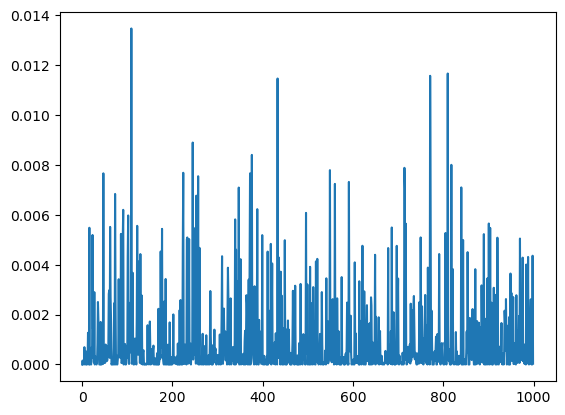

In [ ]:
import matplotlib.pyplot as plt
plt.plot(out.weights[1])

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9
0,-0.266003,-2.326927,-0.167144,0.453611,0.812868,-1.006852,-0.641708,0.731970,-0.588226,-1.455783
1,-0.751619,0.264833,1.360680,-0.362382,0.138664,-1.288945,1.163419,-1.434050,2.383210,0.829570
2,0.817424,1.356615,-0.552565,-1.355037,1.316007,0.081166,0.918712,1.113968,0.981624,-2.022905
3,-0.250678,-0.086365,-1.141409,0.497923,-0.013811,-0.207577,0.046045,0.436048,-0.783918,-1.346805
4,-0.774400,0.788283,-0.949928,-0.411523,-0.582428,0.793978,0.703432,0.262494,-1.692180,0.417725
...,...,...,...,...,...,...,...,...,...,...
995,1.559576,-0.306926,-0.381987,-1.133386,-0.413252,0.162760,0.327102,-0.810778,-0.614363,-1.354231
996,-1.213105,-1.096146,0.742233,0.941367,-0.054013,0.305591,-0.704571,-0.151366,-1.890847,-0.507476
997,-1.445236,0.902850,0.298827,1.549959,-0.923840,-1.026148,-1.958187,0.818318,-0.223226,-1.724601
998,0.253199,-1.608266,-0.806056,0.681402,-1.294518,2.019172,0.839666,0.165261,-0.255498,-0.301274


In [ ]:
Y

,0,1
0,-0.912819,-2.529923
1,-0.999677,-0.200527
2,0.717756,-0.162220
3,-1.885987,-0.082575
4,-1.494624,-0.539509
...,...,...
995,2.020581,0.128688
996,-1.513625,0.063839
997,-2.208074,-0.002965
998,0.646438,0.023884
